In [1]:
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications.resnet50 import decode_predictions
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import json
import cv2
import random
import sys
import os

import sys
import os

# Get the absolute path of the src folder
sys.path.append(os.path.abspath("src"))


from utils import show_image, preprocess_image, clip_eps, get_label
from watermark import generate_adversaries_targeted, perturb_image, verify_watermark

2025-02-09 21:21:52.010964: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-09 21:21:52.011006: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-09 21:21:52.012658: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-09 21:21:52.022894: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
EPS = 2./255
IMAGENET_LABELS = "./data/imagenet_class_index.json"

with open(IMAGENET_LABELS) as f:
    IMAGENET_CLASSES = {int(i):x[1] for i,x in json.load(f).items()}

In [3]:
k = 4
secret_labels = random.sample(range(1000), k)
print("Secret labels:", secret_labels)
print("Secret label names:", [IMAGENET_CLASSES[label] for label in secret_labels])

Secret labels: [305, 881, 184, 1]
Secret label names: ['dung_beetle', 'upright', 'Irish_terrier', 'goldfish']


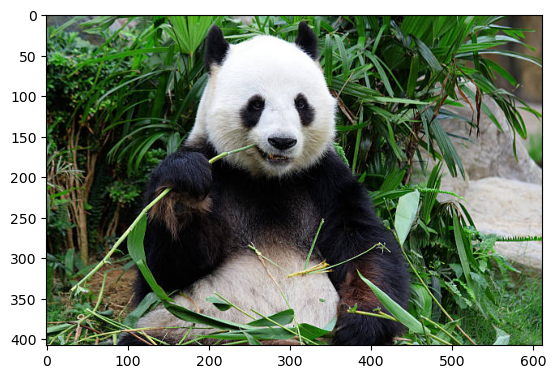

2025-02-09 21:21:55.717112: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10534 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:89:00.0, compute capability: 6.1


In [4]:
sample_image = show_image("./data/imagenet/giant_panda/giantpanda.jpg")
preprocessed_image = preprocess_image(sample_image, preprocess=True)
resnet50 = tf.keras.applications.ResNet50(weights="imagenet")

In [5]:
preds = resnet50.predict(preprocessed_image)
print("Predicted:", decode_predictions(preds, top=3)[0])
print("Class idx:", preds.argmax())

2025-02-09 21:21:59.592913: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


1/1 [==============================] - 2s 2s/step
Predicted: [('n02510455', 'giant_panda', 0.99872273), ('n02509815', 'lesser_panda', 0.0005726167), ('n02488702', 'colobus', 0.0002929433)]
Class idx: 388


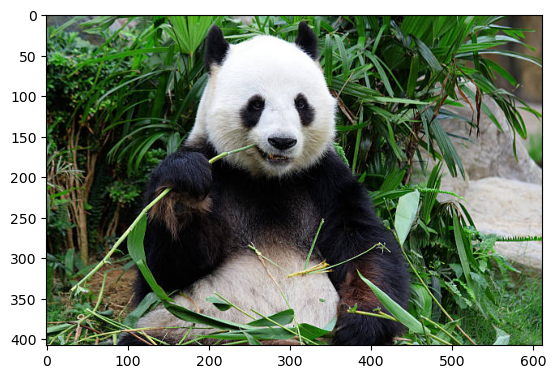

1/1 [==============================] - 0s 39ms/step
[[6.14646893e-08 1.46803432e-08 2.56094301e-09 3.33700467e-09
  1.22387478e-09 1.27254340e-09 1.70836212e-09 5.26242978e-08
  2.04898697e-07 8.47845794e-09 1.62415004e-09 4.75172506e-08
  9.70621916e-10 8.58047855e-09 6.59958044e-09 2.34763409e-09
  9.69582548e-09 1.50505585e-07 2.45204518e-07 4.80806719e-08
  5.47557644e-09 2.12307839e-07 5.94234741e-08 3.01437490e-06
  1.84516054e-07 2.65057611e-08 2.56392929e-09 2.71538347e-09
  3.77248233e-09 1.54458757e-08 2.22469287e-09 1.38647538e-08
  4.78076778e-09 1.54958641e-08 6.08902084e-09 5.19032595e-09
  3.80329283e-07 5.98295680e-09 1.05774389e-09 1.52171165e-08
  2.90707503e-09 1.28330468e-09 1.55118620e-08 8.10057710e-09
  7.36720995e-09 3.69962216e-09 6.87707447e-09 4.45846071e-09
  5.16893017e-08 2.17831335e-08 4.10018020e-09 9.67299982e-08
  1.26169732e-08 1.39841614e-08 1.85766034e-08 1.12809335e-08
  4.74403699e-08 2.40383056e-08 2.81166539e-08 8.27449220e-09
  8.21149371e-09 4

/opt/conda/lib/python3.11/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Iteration 0, Loss: 74.35932159423828


2025-02-09 21:22:02.311189: I external/local_xla/xla/service/service.cc:168] XLA service 0x556e3828fa60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-09 21:22:02.311211: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2025-02-09 21:22:02.319395: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739164922.502056    1261 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Iteration 20, Loss: 54.3256721496582
Iteration 40, Loss: 42.470863342285156
Iteration 60, Loss: 37.11361312866211
Iteration 80, Loss: 35.60599136352539
Iteration 100, Loss: 34.92152404785156
Iteration 120, Loss: 34.41046142578125
Iteration 140, Loss: 33.93539810180664
Iteration 160, Loss: 33.50859069824219
Iteration 180, Loss: 33.13029861450195
Iteration 200, Loss: 32.77839660644531
Iteration 220, Loss: 32.44906997680664
Iteration 240, Loss: 32.112857818603516
Iteration 260, Loss: 31.802202224731445
Iteration 280, Loss: 31.50399398803711
Iteration 300, Loss: 31.23059844970703
Iteration 320, Loss: 30.951122283935547
Iteration 340, Loss: 30.654462814331055


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


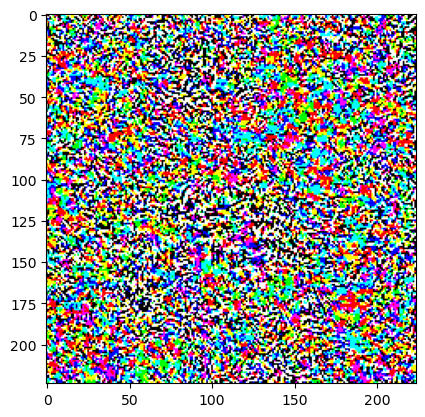

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


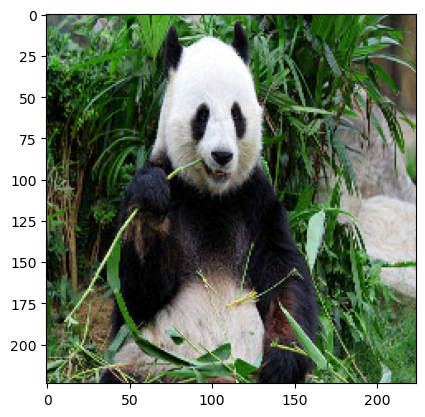

1/1 [==============================] - 0s 40ms/step
[[1.17204268e-03 9.47173394e-04 6.34567186e-05 1.04854473e-04
  5.61016277e-05 7.17735165e-05 8.63916721e-05 1.70735142e-03
  1.09809393e-03 2.08319703e-04 1.16177056e-04 1.06794480e-03
  1.62086682e-04 3.79524223e-04 2.12580446e-04 3.46833025e-04
  5.05519798e-04 1.58898672e-03 1.18815771e-03 5.82296285e-04
  4.19384101e-04 2.04318599e-03 1.36319327e-03 9.48558375e-03
  1.42437010e-03 1.06723560e-03 2.80457723e-04 2.00228606e-04
  2.74976745e-04 6.43929234e-04 2.65125884e-04 1.73794819e-04
  2.24985924e-04 4.18377836e-04 4.72651969e-04 3.27651360e-04
  3.41127533e-03 3.65475484e-04 1.01646860e-04 7.19978299e-04
  1.73597946e-04 1.78641028e-04 2.27316821e-04 3.36665311e-04
  1.89520229e-04 2.04312659e-04 5.13112987e-04 2.91526987e-04
  4.70572762e-04 5.98713581e-04 2.28084129e-04 9.90235945e-04
  3.17426020e-04 1.29892107e-03 6.52322604e-04 1.15887355e-03
  5.30755438e-04 8.33566242e-04 1.08722202e-03 3.25213507e-04
  4.05892002e-04 9

In [6]:
#@title Adam
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)
perturb_image("./examples/panda.jpg", 388, secret_labels, resnet50, optimizer,EPS)